In [1]:
!pip install SimpleITK

In [1]:
import matplotlib.pyplot as plt
import os
import sys
import SimpleITK as sitk
import numpy as np

In [3]:
def get_files(data_path, folder):
    names = []
    folder_path = os.path.join(data_path, folder)
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        for file in os.listdir(subfolder_path):
            if file.endswith(".nrrd") and not file.endswith(".seg.nrrd"):
                names.append(os.path.join(subfolder_path, file))
    return names

Data_path = r"/content/drive/MyDrive/Aorta_Segmentation/Data"

Dongyang_data_names = get_files(Data_path, "Dongyang")
KiTS_data_names = get_files(Data_path, "KiTS")
Rider_data_names = get_files(Data_path, "Rider")

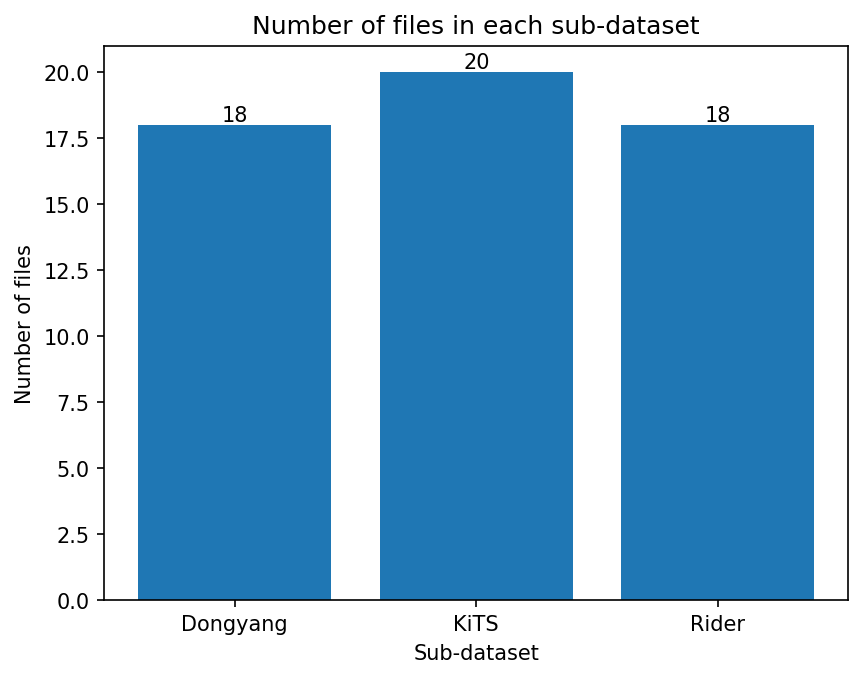

In [ ]:
names = ["Dongyang", "KiTS", "Rider"]
n_files = [len(Dongyang_data_names), len(KiTS_data_names), len(Rider_data_names)]

plt.figure(dpi=150)
plt.bar(names, n_files)
for i, n in enumerate(n_files):
    plt.text(i, n, str(n), ha='center', va='bottom')
plt.title("Number of files in each sub-dataset")
plt.xlabel("Sub-dataset")
plt.ylabel("Number of files")
plt.show()

In [4]:
def get_images(data_names):
  lst = []
  lst_sizes = []
  for name in data_names:
    image = sitk.ReadImage(name)
    image = sitk.GetArrayFromImage(image).T
    lst_sizes.append(image.shape[2])
    for i in range(image.shape[2]):
        lst.append(image[:, :, i])
  return lst, lst_sizes

Dongyang_lst, Dongyang_lst_sizes = get_images(Dongyang_data_names)
KiTS_lst, KiTS_lst_sizes = get_images(KiTS_data_names)
Rider_lst, Rider_lst_sizes  = get_images(Rider_data_names)

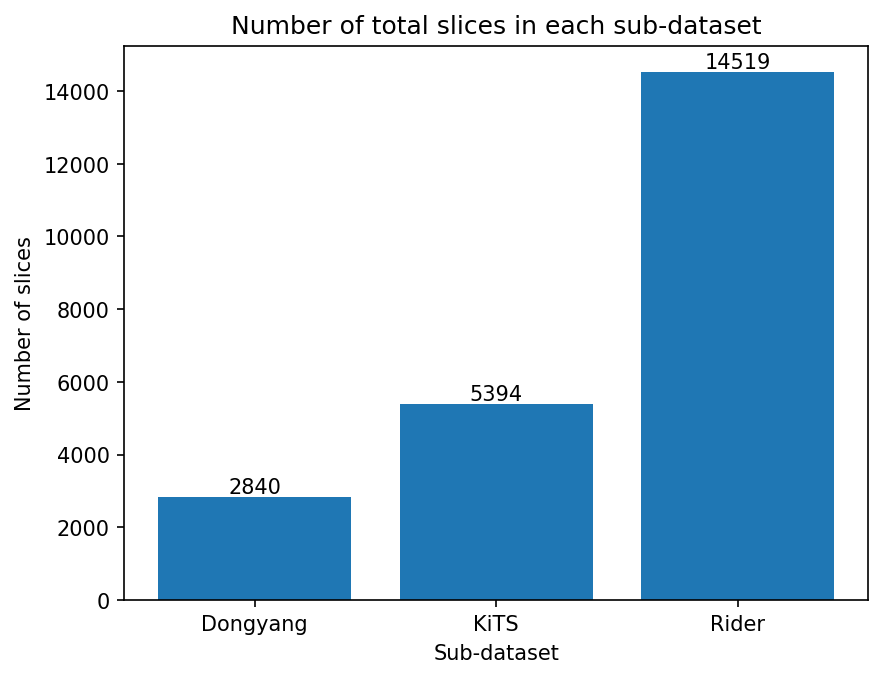

In [5]:
names = ["Dongyang", "KiTS", "Rider"]
n_slices = [len(Dongyang_lst), len(KiTS_lst), len(Rider_lst)]

plt.figure(dpi=150)
plt.bar(names, n_slices)
for i, n in enumerate(n_slices):
    plt.text(i, n, str(n), ha='center', va='bottom')
plt.title("Number of total slices in each sub-dataset")
plt.xlabel("Sub-dataset")
plt.ylabel("Number of slices")
plt.show()

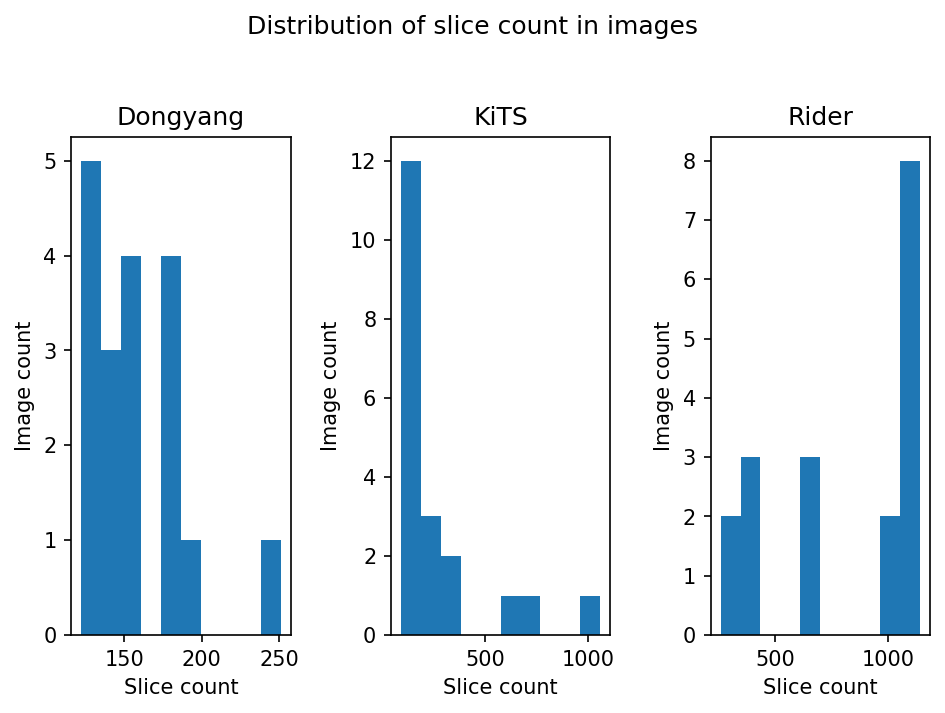

In [ ]:
plt.figure(dpi=150)
plt.suptitle("Distribution of slice count in images")

plt.subplot(1, 3, 1)
plt.hist(Dongyang_lst_sizes, bins=10)
plt.title("Dongyang")
plt.xlabel("Slice count")
plt.ylabel("Image count")

plt.subplot(1, 3, 2)
plt.hist(KiTS_lst_sizes, bins=10)
plt.title("KiTS")
plt.xlabel("Slice count")
plt.ylabel("Image count")

plt.subplot(1, 3, 3)
plt.hist(Rider_lst_sizes, bins=10)
plt.title("Rider")
plt.xlabel("Slice count")
plt.ylabel("Image count")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [4]:
def get_voxels(data_names):
  lst = []
  for name in data_names:
    image = sitk.ReadImage(name)
    image = sitk.GetArrayFromImage(image).T
    lst.append(image.flatten())
  return np.concatenate(lst)

Dongyang_voxels = get_voxels(Dongyang_data_names)
KiTS_voxels = get_voxels(KiTS_data_names)
Rider_voxels  = get_voxels(Rider_data_names)

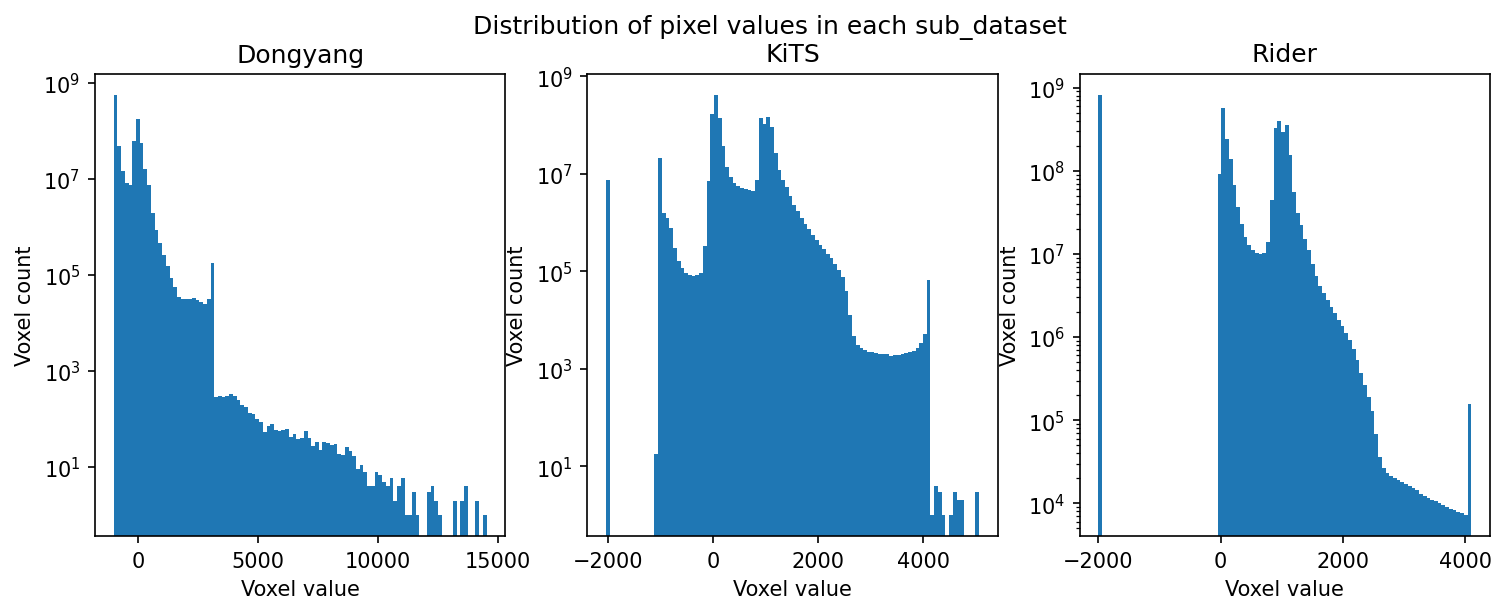

In [ ]:
plt.figure(figsize=(12, 4), dpi=150)
plt.suptitle("Distribution of voxel values in each sub_dataset")

plt.subplot(1, 3, 1)
plt.hist(Dongyang_voxels, bins=100)
plt.yscale('log')
plt.title("Dongyang")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.subplot(1, 3, 2)
plt.hist(KiTS_voxels, bins=100)
plt.yscale('log')
plt.title("KiTS")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.subplot(1, 3, 3)
plt.hist(Rider_voxels, bins=100)
plt.yscale('log')
plt.title("Rider")
plt.xlabel("Voxel value")
plt.ylabel("Voxel count")

plt.show()